# Task Advanced. Data preprocessing and crossvalidation.

## Module 11. Scalable Data processing: Machine learning and Streaming

## Pablo Yañez Martin

In [1]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SparkSession
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
import matplotlib.pyplot as plt

In [2]:
spark_session = SparkSession \
    .builder \
    .appName("Task Advanced: Data preprocessing and crossvalidation") \
    .master("local[*]") \
    .getOrCreate()

#### Step 1. Read the CSV inferring the scheme.

In [3]:
df = spark_session\
    .read\
    .options(inferSchema='True')\
    .csv("D:\Dropbox\Pablo\Master\Modulo 11. Scalable Data processing. Machine Learning and Streaming\Practicas\Datos\wine.data")\
    .toDF("label", "feature1", "feature2", "feature3", "feature4", "feature5", "feature6", "feature7", "feature8", "feature9", "feature10", "feature11", "feature12", "feature13")

In [4]:
df.printSchema()
df.show()

root
 |-- label: integer (nullable = true)
 |-- feature1: double (nullable = true)
 |-- feature2: double (nullable = true)
 |-- feature3: double (nullable = true)
 |-- feature4: double (nullable = true)
 |-- feature5: integer (nullable = true)
 |-- feature6: double (nullable = true)
 |-- feature7: double (nullable = true)
 |-- feature8: double (nullable = true)
 |-- feature9: double (nullable = true)
 |-- feature10: double (nullable = true)
 |-- feature11: double (nullable = true)
 |-- feature12: double (nullable = true)
 |-- feature13: integer (nullable = true)

+-----+--------+--------+--------+--------+--------+--------+--------+--------+--------+---------+---------+---------+---------+
|label|feature1|feature2|feature3|feature4|feature5|feature6|feature7|feature8|feature9|feature10|feature11|feature12|feature13|
+-----+--------+--------+--------+--------+--------+--------+--------+--------+--------+---------+---------+---------+---------+
|    1|   14.23|    1.71|    2.43|    15.6|

#### Step 2. Transforming the read dataframe into another one with the format required by SparkML.

In [5]:
vecAssembler = VectorAssembler(inputCols=["feature1", "feature2", "feature3", "feature4", "feature5", "feature6", "feature7", "feature8", "feature9", "feature10", "feature11", "feature12", "feature13"], outputCol="features")
new_df = vecAssembler.transform(df)
new_df.show()

+-----+--------+--------+--------+--------+--------+--------+--------+--------+--------+---------+---------+---------+---------+--------------------+
|label|feature1|feature2|feature3|feature4|feature5|feature6|feature7|feature8|feature9|feature10|feature11|feature12|feature13|            features|
+-----+--------+--------+--------+--------+--------+--------+--------+--------+--------+---------+---------+---------+---------+--------------------+
|    1|   14.23|    1.71|    2.43|    15.6|     127|     2.8|    3.06|    0.28|    2.29|     5.64|     1.04|     3.92|     1065|[14.23,1.71,2.43,...|
|    1|    13.2|    1.78|    2.14|    11.2|     100|    2.65|    2.76|    0.26|    1.28|     4.38|     1.05|      3.4|     1050|[13.2,1.78,2.14,1...|
|    1|   13.16|    2.36|    2.67|    18.6|     101|     2.8|    3.24|     0.3|    2.81|     5.68|     1.03|     3.17|     1185|[13.16,2.36,2.67,...|
|    1|   14.37|    1.95|     2.5|    16.8|     113|    3.85|    3.49|    0.24|    2.18|      7.8|  

#### Step 3. Select a classifier and train it using crossvalidation.

In [6]:
(trainingData, testData) = new_df.randomSplit([0.8, 0.2])

In [7]:
decision_tree = DecisionTreeClassifier(labelCol="label", featuresCol="features")
model = decision_tree.fit(trainingData)

In [8]:
paramGrid = (ParamGridBuilder()
             .addGrid(decision_tree.maxDepth, [2, 5, 10, 20, 30])
             .addGrid(decision_tree.maxBins, [10, 20, 40, 80, 100])
             .build())

In [9]:
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

In [10]:
train_validation_split = TrainValidationSplit(estimator=decision_tree,
                           estimatorParamMaps=paramGrid,
                           evaluator=evaluator,
                           trainRatio=0.8)

In [11]:
model = train_validation_split.fit(trainingData)

#### Step 4. Analyze the quality of the classifier.

In [12]:
predictions = model.transform(testData)
predictions\
    .select("prediction", "label", "features")\
    .show(5)

+----------+-----+--------------------+
|prediction|label|            features|
+----------+-----+--------------------+
|       1.0|    1|[12.85,1.6,2.52,1...|
|       1.0|    1|[13.72,1.43,2.5,1...|
|       1.0|    1|[13.73,1.5,2.7,22...|
|       1.0|    1|[13.83,1.57,2.62,...|
|       1.0|    1|[13.9,1.68,2.12,1...|
+----------+-----+--------------------+
only showing top 5 rows



In [13]:
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

Test Error = 0.0666667


Running this notebook, several times, I have obtained the following list of test error:

In [14]:
test_error_decision_tree = [0.157895,0.15625,0.222222,0.125,0.139535, 0.108108, 0.102564,0,0.0384615, 0.114286, 0.0740741, 0,0.0909091,0.121212, 0.117647, 0.195652, 0.0833333,0.025641,0.137931,0.111111, 0.125, 0.1875, 0.027027, 0.0285714, 0.0294118]
print(len(test_error_decision_tree))

25


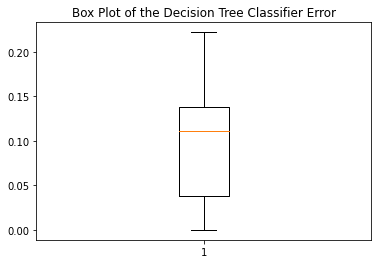

In [15]:
plt.boxplot(test_error_decision_tree)
plt.title("Box Plot of the Decision Tree Classifier Error")
plt.show()

In the box plot, we can see that the majority of values of test error are between 0.04 and 0.14. So, we can say that the quality of our classifier is good, although it could be better.
We can observe that some times, the test error is 0 and others greater than 0.2, which is a bad 